# 导库

In [40]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np
from os import listdir
from os.path import join
from torch.utils.data import Dataset
import torch.optim as optim
from torch.utils.data import DataLoader
from math import log10, exp
import matplotlib.pyplot as plt
from PIL import Image, ImageFilter
from torch.optim.lr_scheduler import MultiStepLR
import math

plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

# 数据预处理/生成

In [2]:
def is_image_file(filename):
    return any(filename.endswith(extension) for extension in [".png", ".jpg", ".jpeg"])


def load_img(filepath):
    img = Image.open(filepath).convert('YCbCr')
    y, _, _ = img.split()
    return y


CROP_SIZE = 300


class DatasetFromFolder(Dataset):
    def __init__(self, image_dir, zoom_factor):
        super(DatasetFromFolder, self).__init__()
        self.image_filenames = [join(image_dir, x)
                                for x in listdir(image_dir) if is_image_file(x)]
        crop_size = CROP_SIZE - (CROP_SIZE % zoom_factor)
        # 从图片中心裁剪成300*300
        self.input_transform = transforms.Compose([transforms.CenterCrop(crop_size),
                                                   transforms.Resize(
                                                       crop_size // zoom_factor),
                                                   transforms.Resize(
                                                       crop_size, interpolation=Image.BICUBIC),
                                                   # BICUBIC 双三次插值
                                                   transforms.ToTensor()])
        self.target_transform = transforms.Compose(
            [transforms.CenterCrop(crop_size), transforms.ToTensor()])

    def __getitem__(self, index):
        input = load_img(self.image_filenames[index])
        target = input.copy()
        input = self.input_transform(input)
        target = self.target_transform(target)
        return input, target

    def __len__(self):
        return len(self.image_filenames)

# 评估指标

## PSNR（Peak Signal to Noise Ratio，峰值信噪比）
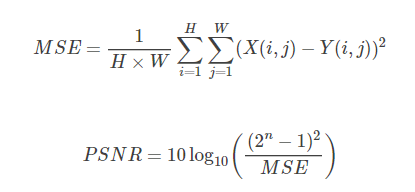

n为每像素的比特数, 即像素灰阶数为256。

PSNR的单位是dB，数值越大表示失真越小。

一般认为PSNR在38以上的时候，人眼就无法区分两幅图片了。

In [16]:
def psnr(loss):
    return 10 * log10(1 / loss.item())

## SSIM（Structural Similarity，结构相似性）
SSIM测量系统由三个对比模块组成：亮度、对比度、结构
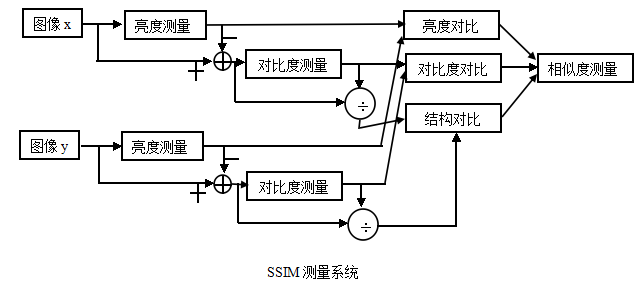

### 亮度对比函数
图像的平均灰度计算公式：

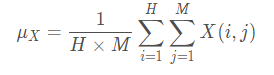

亮度对比函数计算公式：

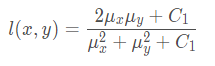

### 对比度对比函数
图像的标准差计算公式：

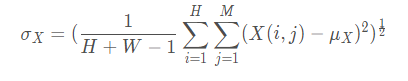

对比度对比函数计算公式：

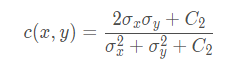

### 结构对比函数
结构对比函数计算公式：

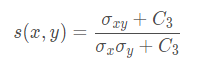


SSIM计算公式：

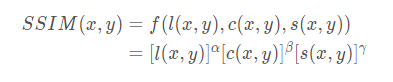

其中，$\alpha$ 、$\beta$、$\gamma >0$, 用来调整这三个模块的重要性

SSIM函数的值域为[0, 1], 值越大说明图像失真越小，两幅图像越相似

由于pytorch没有类似tensorflow类似tf.image.ssim这样计算SSIM的接口，因此根据公式进行自定义函数用来计算

In [17]:
"""
计算ssim函数
"""
# 计算一维的高斯分布向量
def gaussian(window_size, sigma):
    gauss = torch.Tensor(
        [exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


# 创建高斯核，通过两个一维高斯分布向量进行矩阵乘法得到
# 可以设定channel参数拓展为3通道
def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(
        _1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(
        channel, 1, window_size, window_size).contiguous()
    return window


# 计算SSIM
# 直接使用SSIM的公式，但是在计算均值时，不是直接求像素平均值，而是采用归一化的高斯核卷积来代替。
# 在计算方差和协方差时用到了公式Var(X)=E[X^2]-E[X]^2, cov(X,Y)=E[XY]-E[X]E[Y].
def ssim(img1, img2, window_size=11, window=None, size_average=True, full=False, val_range=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    if val_range is None:
        if torch.max(img1) > 128:
            max_val = 255
        else:
            max_val = 1

        if torch.min(img1) < -0.5:
            min_val = -1
        else:
            min_val = 0
        L = max_val - min_val
    else:
        L = val_range

    padd = 0
    (_, channel, height, width) = img1.size()
    if window is None:
        real_size = min(window_size, height, width)
        window = create_window(real_size, channel=channel).to(img1.device)

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd,
                         groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd,
                         groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd,
                       groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    if size_average:
        ret = ssim_map.mean()
    else:
        ret = ssim_map.mean(1).mean(1).mean(1)

    if full:
        return ret, cs
    return ret


class SSIM(torch.nn.Module):
    def __init__(self, window_size=11, size_average=True, val_range=None):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.val_range = val_range

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.dtype == img1.dtype:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(
                img1.device).type(img1.dtype)
            self.window = window
            self.channel = channel

        return ssim(img1, img2, window=window, window_size=self.window_size, size_average=self.size_average)

# SRCNN
## SRCNN 网络结构
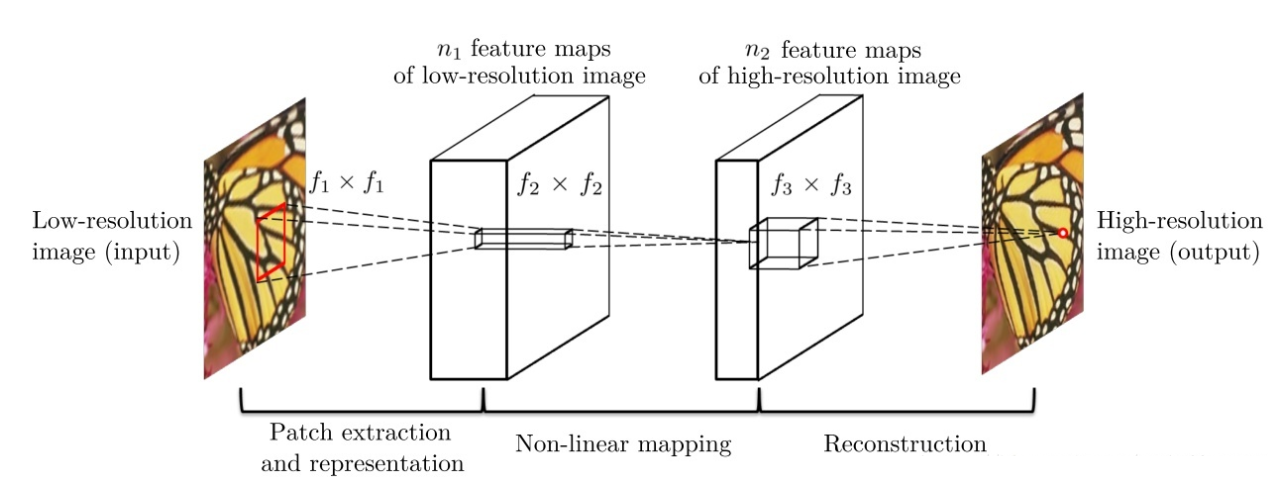

对于一个低分辨率图像，先使用双三次（bicubic）插值将其放大到目标大小，再通过三层卷积网络做非线性映射，得到的结果作为高分辨率图像输出。

作者对于这三层卷积层的解释：

特征块提取和表示：此操作从低分辨率图像Y中提取重叠特征块，并将每个特征块表示为一个高维向量。这些向量包括一组特征图，其数量等于向量的维数。

非线性映射：该操作将每个高维向量非线性映射到另一个高维向量。每个映射向量在概念上都是高分辨率特征块的表示。这些向量同样包括另一组特征图。

重建：该操作聚合上述高分辨率patch-wise（介于像素级别和图像级别的区域）表示，生成最终的高分辨率图像。


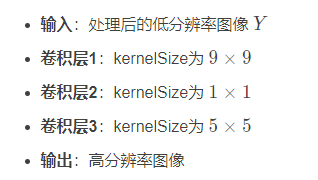

In [15]:
class SRCNN(nn.Module):
    def __init__(self, upscale_factor):
        super(SRCNN, self).__init__()

        self.relu = nn.ReLU()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5, stride=1, padding=2)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(32, upscale_factor ** 2,
                               kernel_size=3, stride=1, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(upscale_factor)

        self._initialize_weights()

    def _initialize_weights(self):
        init.orthogonal_(self.conv1.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv2.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv3.weight, init.calculate_gain('relu'))
        init.orthogonal_(self.conv4.weight)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.pixel_shuffle(x)
        return x

## 参数设置

In [22]:
# 放大倍数
zoom_factor = 2
nb_epochs = 500
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)
torch.cuda.manual_seed(0)
BATCH_SIZE = 4
NUM_WORKERS = 0
trainset = DatasetFromFolder(r"./data/images/train", zoom_factor)
valset = DatasetFromFolder(r"./data/images/train", zoom_factor)
trainloader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
valloader = DataLoader(dataset=valset, batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=NUM_WORKERS)

## 训练/验证
损失函数使用MSE

最后一层的学习率要比前几层小一个数量级

In [21]:
model = SRCNN(1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(
    [
        {"params": model.conv1.parameters(), "lr": 0.0001},
        {"params": model.conv2.parameters(), "lr": 0.0001},
        {"params": model.conv3.parameters(), "lr": 0.00001},
    ]
)


best_psnr = 0.0
for epoch in range(nb_epochs):
    # Train
    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        out = model(input)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    # Val
    sum_psnr = 0.0
    sum_ssim = 0.0
    with torch.no_grad():
        for batch in valloader:
            input, target = batch[0].to(device), batch[1].to(device)
            out = model(input)
            loss = criterion(out, target)
            pr = psnr(loss)
            sm = ssim(input, out)
            sum_psnr += pr
            sum_ssim += sm
    print(f"Average PSNR: {sum_psnr / len(valloader)} dB.")
    print(f"Average SSIM: {sum_ssim / len(valloader)} ")
    avg_psnr = sum_psnr / len(valloader)
    if avg_psnr >= best_psnr:
        best_psnr = avg_psnr
        torch.save(model, r"best_model_SRCNN.pth")

Epoch 0. Training loss: 0.00915052907075733
Average PSNR: 23.588608103174916 dB.
Average SSIM: 0.9556974768638611 
Epoch 1. Training loss: 0.0037449229415506126
Average PSNR: 25.238725223601694 dB.
Average SSIM: 0.9654531478881836 
Epoch 2. Training loss: 0.002893417081795633
Average PSNR: 26.176232787480966 dB.
Average SSIM: 0.9601670503616333 
Epoch 3. Training loss: 0.002438021961133927
Average PSNR: 26.823596550701026 dB.
Average SSIM: 0.9555391669273376 
Epoch 4. Training loss: 0.002191029798705131
Average PSNR: 27.220021555050103 dB.
Average SSIM: 0.9487226605415344 
Epoch 5. Training loss: 0.0020306333317421377
Average PSNR: 27.481394886632593 dB.
Average SSIM: 0.9450040459632874 
Epoch 6. Training loss: 0.001939123128540814
Average PSNR: 27.650534542588222 dB.
Average SSIM: 0.9409930109977722 
Epoch 7. Training loss: 0.0018807333370205015
Average PSNR: 27.75901378336357 dB.
Average SSIM: 0.9394972920417786 
Epoch 8. Training loss: 0.0018426410481333733
Average PSNR: 27.84271735

## 测试

In [28]:
BATCH_SIZE = 4
model_path = "best_model_SRCNN.pth"
testset = DatasetFromFolder(r"./data/images/test", zoom_factor)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)
sum_psnr = 0.0
sum_ssim = 0.0
model = torch.load(model_path).to(device)
criterion = nn.MSELoss()
with torch.no_grad():
    for batch in testloader:
        input, target = batch[0].to(device), batch[1].to(device)
        out = model(input)
        loss = criterion(out, target)
        pr = psnr(loss)
        sm = ssim(input, out)
        sum_psnr += pr
        sum_ssim += sm
print(f"Test Average PSNR: {sum_psnr / len(testloader)} dB")
print(f"Test Average SSIM: {sum_ssim / len(testloader)} ")

Test Average PSNR: 28.576983962714472 dB
Test Average SSIM: 0.9209411144256592 


# FSRCNN
##  FSRCNN网络结构

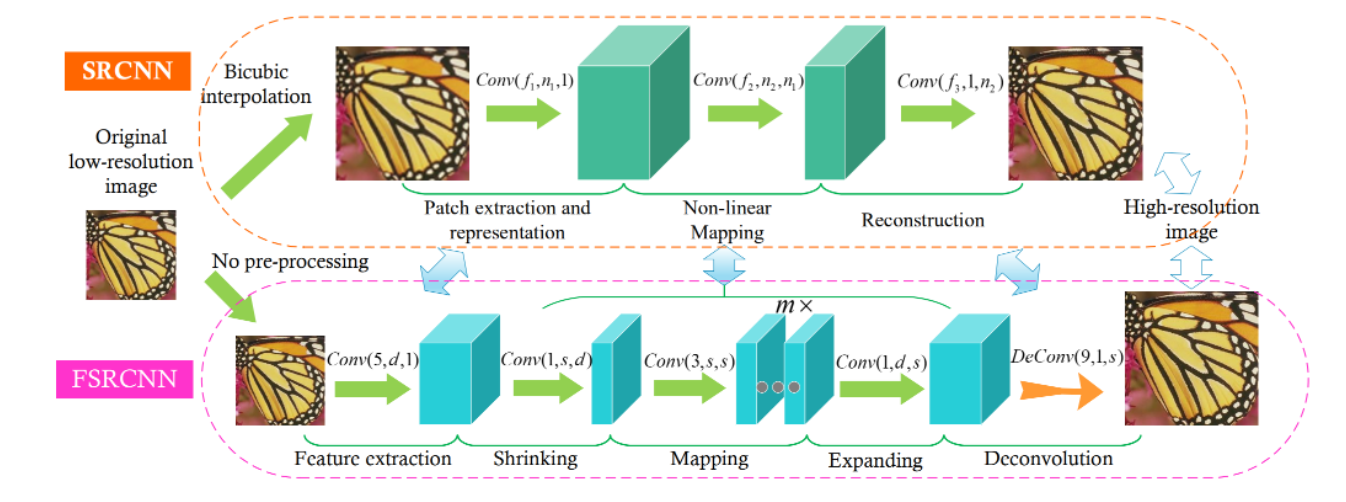

FSRCNN在SRCNN基础上做了如下改变：

1.FSRCNN直接采用低分辨的图像作为输入，不同于SRCNN需要先对低分辨率的图像进行双三次插值然后作为输入；

2.FSRCNN在网络的最后采用反卷积层实现上采样；

3.FSRCNN中没有非线性映射，相应地出现了收缩、映射和扩展；

4.FSRCNN选择更小尺寸的滤波器和更深的网络结构。

各层结构：

- 输入层：FSRCNN不使用bicubic插值来对输入图像做上采样，它直接进入特征提取层
- 特征提取层：采用1 × d × ( 5 × 5 )的卷积层提取
- 收缩层：采用d × s × ( 1 × 1 ) 的卷积层去减少通道数，来减少模型复杂度
- 映射层：采用s × s × ( 3 × 3 ) 卷积层去增加模型非线性度来实现LR → SR 的映射
- 扩张层：该层和收缩层是对称的，采用s × d × ( 1 × 1 ) 卷积层去增加重建的表现力
- 反卷积层：s × 1 × ( 9 × 9 ) 
- 输出层：输出HR图像

In [9]:
class FSRCNN(nn.Module):
    def __init__(self, scale_factor, num_channels=1, d=56, s=12, m=4):
        super(FSRCNN, self).__init__()
        self.first_part = nn.Sequential(
            nn.Conv2d(num_channels, d, kernel_size=5, padding=5//2),
            nn.PReLU(d)
        )
        self.mid_part = [nn.Conv2d(d, s, kernel_size=1), nn.PReLU(s)]
        for _ in range(m):
            self.mid_part.extend([nn.Conv2d(s, s, kernel_size=3, padding=3//2), nn.PReLU(s)])
        self.mid_part.extend([nn.Conv2d(s, d, kernel_size=1), nn.PReLU(d)])
        self.mid_part = nn.Sequential(*self.mid_part)
        self.last_part = nn.ConvTranspose2d(d, num_channels, kernel_size=9, stride=scale_factor, padding=9//2,
                                            output_padding=scale_factor-1)

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.first_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        for m in self.mid_part:
            if isinstance(m, nn.Conv2d):
                nn.init.normal_(m.weight.data, mean=0.0, std=math.sqrt(2/(m.out_channels*m.weight.data[0][0].numel())))
                nn.init.zeros_(m.bias.data)
        nn.init.normal_(self.last_part.weight.data, mean=0.0, std=0.001)
        nn.init.zeros_(self.last_part.bias.data)

    def forward(self, x):
        x = self.first_part(x)
        x = self.mid_part(x)
        x = self.last_part(x)
        return x

## 训练/验证

In [12]:
model = FSRCNN(1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-2)
scheduler = MultiStepLR(optimizer, milestones=[50, 75, 100], gamma=0.1)
best_psnr = 0.0
for epoch in range(nb_epochs):
    # Train
    epoch_loss = 0
    for iteration, batch in enumerate(trainloader):
        input, target = batch[0].to(device), batch[1].to(device)
        optimizer.zero_grad()
        out = model(input)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    print(f"Epoch {epoch}. Training loss: {epoch_loss / len(trainloader)}")
    # Val
    sum_psnr = 0.0
    sum_ssim = 0.0
    with torch.no_grad():
        for batch in valloader:
            input, target = batch[0].to(device), batch[1].to(device)
            out = model(input)
            loss = criterion(out, target)
            pr = psnr(loss)
            sm = ssim(input, out)
            sum_psnr += pr
            sum_ssim += sm
    print(f"Average PSNR: {sum_psnr / len(valloader)} dB.")
    print(f"Average SSIM: {sum_ssim / len(valloader)} ")
    avg_psnr = sum_psnr / len(valloader)
    if avg_psnr >= best_psnr:
        best_psnr = avg_psnr
        torch.save(model, r"best_model_FSRCNN.pth")
    scheduler.step()

Epoch 0. Training loss: 34.78852433741093
Average PSNR: 3.8701000650416937 dB.
Average SSIM: 0.013258066959679127 
Epoch 1. Training loss: 0.060397018920630215
Average PSNR: 18.759079178739874 dB.
Average SSIM: 0.6331508159637451 
Epoch 2. Training loss: 0.011997964512556792
Average PSNR: 19.972020224139772 dB.
Average SSIM: 0.6900234222412109 
Epoch 3. Training loss: 0.009592332458123565
Average PSNR: 20.75904663496465 dB.
Average SSIM: 0.7364702224731445 
Epoch 4. Training loss: 0.008481605537235736
Average PSNR: 21.074949152942704 dB.
Average SSIM: 0.7520724534988403 
Epoch 5. Training loss: 0.008011158090084791
Average PSNR: 21.31993703227245 dB.
Average SSIM: 0.7609509229660034 
Epoch 6. Training loss: 0.007626048340462148
Average PSNR: 21.537199329095888 dB.
Average SSIM: 0.7690988779067993 
Epoch 7. Training loss: 0.007326159509830177
Average PSNR: 21.647838659998726 dB.
Average SSIM: 0.7743013501167297 
Epoch 8. Training loss: 0.007147906199097633
Average PSNR: 21.7587512009252

## 测试

In [29]:
BATCH_SIZE = 4
model_path = "best_model_FSRCNN.pth"
testset = DatasetFromFolder(r"./data/images/test", zoom_factor)
testloader = DataLoader(dataset=testset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=NUM_WORKERS)
sum_psnr = 0.0
sum_ssim = 0.0
model = torch.load(model_path).to(device)
criterion = nn.MSELoss()
with torch.no_grad():
    for batch in testloader:
        input, target = batch[0].to(device), batch[1].to(device)
        out = model(input)
        loss = criterion(out, target)
        pr = psnr(loss)
        sm = ssim(input, out)
        sum_psnr += pr
        sum_ssim += sm
print(f"Test Average PSNR: {sum_psnr / len(testloader)} dB")
print(f"Test Average SSIM: {sum_ssim / len(testloader)} ")

Test Average PSNR: 26.983568214049093 dB
Test Average SSIM: 0.9330624938011169 


# 实图测试

同比例原图

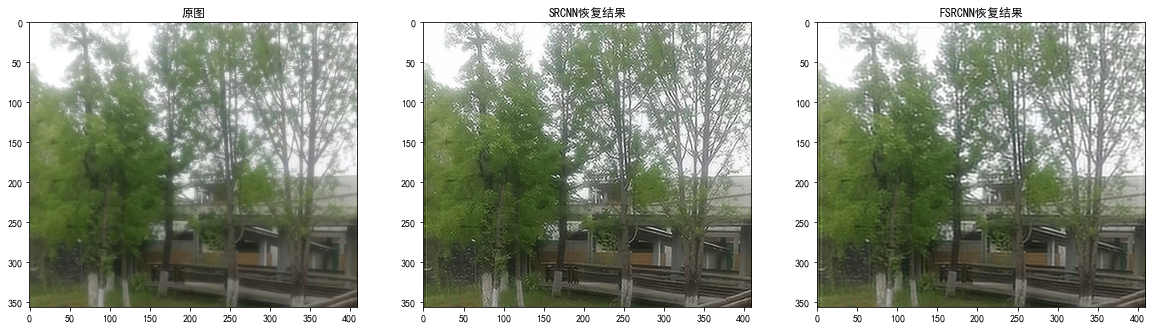

In [44]:
# 参数设置
zoom_factor = 1
model = "best_model_SRCNN.pth"
model2 = "best_model_FSRCNN.pth"
image = "tree.png"
cuda = 'store_true'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 读取图片
img = Image.open(image).convert('YCbCr')
img = img.resize((int(img.size[0] * zoom_factor), int(img.size[1] * zoom_factor)), Image.BICUBIC)
y, cb, cr = img.split()
img_to_tensor = transforms.ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)

# 输出图片
model = torch.load(model).to(device)
out = model(input).cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')

model2 = torch.load(model2).to(device)
out2 = model2(input).cpu()
out_img_y2 = out2[0].detach().numpy()
out_img_y2 *= 255.0
out_img_y2 = out_img_y2.clip(0, 255)
out_img_y2 = Image.fromarray(np.uint8(out_img_y2[0]), mode='L')
out_img2 = Image.merge('YCbCr', [out_img_y2, cb, cr]).convert('RGB')

# 绘图显示
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img)
ax[0].set_title("原图")
ax[1].imshow(out_img)
ax[1].set_title("SRCNN恢复结果")
ax[2].imshow(out_img2)
ax[2].set_title("FSRCNN恢复结果")
plt.show()
fig.savefig(r"tree2.png")

放大两倍

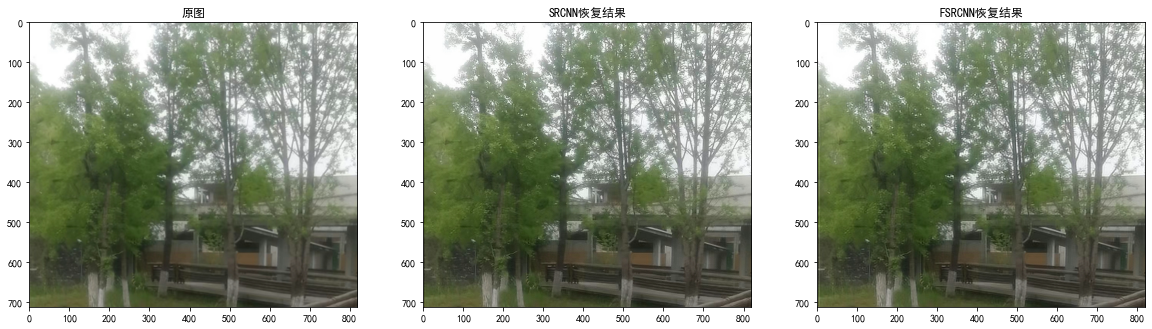

In [47]:
# 参数设置
zoom_factor = 2
model = "best_model_SRCNN.pth"
model2 = "best_model_FSRCNN.pth"
image = "tree.png"
cuda = 'store_true'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 读取图片
img = Image.open(image).convert('YCbCr')
img = img.resize((int(img.size[0] * zoom_factor), int(img.size[1] * zoom_factor)), Image.BICUBIC)
y, cb, cr = img.split()
img_to_tensor = transforms.ToTensor()
input = img_to_tensor(y).view(1, -1, y.size[1], y.size[0]).to(device)

# 输出图片
model = torch.load(model).to(device)
out = model(input).cpu()
out_img_y = out[0].detach().numpy()
out_img_y *= 255.0
out_img_y = out_img_y.clip(0, 255)
out_img_y = Image.fromarray(np.uint8(out_img_y[0]), mode='L')
out_img = Image.merge('YCbCr', [out_img_y, cb, cr]).convert('RGB')

model2 = torch.load(model2).to(device)
out2 = model2(input).cpu()
out_img_y2 = out2[0].detach().numpy()
out_img_y2 *= 255.0
out_img_y2 = out_img_y2.clip(0, 255)
out_img_y2 = Image.fromarray(np.uint8(out_img_y2[0]), mode='L')
out_img2 = Image.merge('YCbCr', [out_img_y2, cb, cr]).convert('RGB')

# 绘图显示
fig, ax = plt.subplots(1, 3, figsize=(20, 20))
ax[0].imshow(img)
ax[0].set_title("原图")
ax[1].imshow(out_img)
ax[1].set_title("SRCNN恢复结果")
ax[2].imshow(out_img2)
ax[2].set_title("FSRCNN恢复结果")
plt.show()
fig.savefig(r"tree3.png")